# 🧬 NTv3 Multi-Scale Interpretation Tutorial

This notebook demonstrates how to use the **NTv3 post-trained model** for multi-scale interpretation of regulatory logic, enabling analysis from individual nucleotides to enhancer elements and full gene loci.

> 📝 **Note for Google Colab users:** This notebook is compatible with Colab! For faster inference, make sure to enable GPU: Runtime → Change runtime type → GPU (T4 or better recommended).

## 📋 Overview

Given a genomic window from the **human genome (hg38)**, we demonstrate four complementary interpretability modalities:

1. **Predicted functional tracks** - Regulatory activity across thousands of assays
2. **Predicted genome annotations** - Gene-structural and regulatory elements at base-pair resolution
3. **Transformer attention maps** - How the model integrates information across long genomic distances
4. **Gradient-based saliency maps** - Sequence positions most influential for predictions

> 💡 **Note:** Functional tracks and genomic element annotations are predicted only for the center 37.5% of the input sequence.

## 📚 Notebook Structure

1. **Setup**: Install dependencies and configure the analysis
2. **Data Loading**: Fetch the genomic sequence from UCSC
3. **Model Loading**: Load the NTv3 post-trained model and tokenizers
4. **Inference**: Run the model to generate predictions and extract attention
5. **Functional Tracks**: Visualize predicted regulatory tracks
6. **Genome Annotations**: Visualize predicted genomic elements
7. **Attention Maps**: Analyze long-range information
8. **Saliency Maps**: Compute gradient-based sequence attributions


## 0) 📦 Imports + Setup


In [ ]:
# Login to HuggingFace (required for gated models)
from huggingface_hub import login
login()

In [1]:
# Install dependencies
!pip -q install "transformers>=4.55" "huggingface_hub>=0.23" safetensors torch requests seaborn matplotlib numpy seam-nn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.8 MB/s eta 0:00:00


In [3]:
import os
import math
import warnings
import logging

import torch
import torch.nn.functional as F
from transformers import AutoConfig, AutoModel, AutoTokenizer

import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda" and torch.cuda.get_device_capability(0)[0] >= 8:
    dtype = torch.bfloat16
else:
    dtype = torch.float16
print(f"Device: {device}, dtype: {dtype}")

Device: cuda, dtype: torch.float16


## 1) 📦 Configuration

Set your NTv3 model and genomic window here. Following the manuscript methods, all sequences are handled in the hg38 coordinate system.

> 💡 **Note:** For a T4 GPU, we recommend using an input sequence length of 32kb or shorter.

In [4]:
# -----------------------------
# User Configuration
# -----------------------------
model_name = "InstaDeepAI/NTv3_650M_post"

# Genomic window (must be multiple of 128 due to model downsampling)
species = "human"
chrom = "chr11"
center_position = 5_269_945  # Center of region of interest (HBE1 locus)
sequence_length = 32_768 # use 131kb window on A100, 32_768 on T4 GPU

# Calculate start/end from center
start = center_position - sequence_length // 2
end = center_position + sequence_length // 2

# Analysis parameters
token_resolution = 128  # bp per token

assembly = "hg38"

print(f"Model: {model_name}")
print(f"Region: {chrom}:{start:,}-{end:,} ({sequence_length:,} bp)")
print(f"Center: {center_position:,}")
print(f"Species: {species} -> Assembly: {assembly}")

Model: InstaDeepAI/NTv3_650M_post
Region: chr11:5,253,561-5,286,329 (32,768 bp)
Center: 5,269,945
Species: human -> Assembly: hg38


## 2) 📥 Fetch Chromosome Sequence


In [5]:
# Get the sequence from the UCSC API
url = (
    f"https://api.genome.ucsc.edu/getData/sequence?"
    f"genome={assembly};chrom={chrom};start={start};end={end}"
)
seq = requests.get(url).json()["dna"].upper()
print(f"Original sequence length: {len(seq):,} bp")

# Crop to multiple of 128 (ensures clean tokenization)
seq = seq[:int(len(seq) // 128) * 128]
n_tokens = len(seq) / 128
print(
    f"Cropped sequence length: {len(seq):,} bp "
    f"({n_tokens:.0f} transformer tokens)"
)
print(f"First 100 bp: {seq[:100]}")


Original sequence length: 32,768 bp
Cropped sequence length: 32,768 bp (256 transformer tokens)
First 100 bp: AGTTGTTCTTCTTGCAGCACTAGTCACTGGCCATAATTTAAATCTTGTTATCTTCTTGCCACCATGAACCCTGTATGCTGTAGGCTGAAAACGTTAAAAG


## 3) 🤖 Load NTv3 Model + Tokenizers


In [6]:
# Load model configuration
print("Loading model configuration...")
cfg = AutoConfig.from_pretrained(model_name, trust_remote_code=True)

# Load model
print("Loading model...")
model = AutoModel.from_pretrained(
    model_name,
    trust_remote_code=True,
).to(device)
model.eval()

# Load tokenizers
print("Loading tokenizers...")
tokenizer = AutoTokenizer.from_pretrained(
    model_name, trust_remote_code=True
)


print(f"\n✅ Model loaded successfully")
print(f"   Supported species: {model.supported_species}")
n_bigwigs = len(model.config.bigwigs_per_species[species])
print(f"   Number of BigWig tracks: {n_bigwigs}")
print(f"   Number of BED elements: {len(cfg.bed_elements_names)}")


Loading model configuration...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/339k [00:00<?, ?B/s]

configuration_ntv3_posttrained.py:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

configuration_ntv3_pretrained.py:   0%|          | 0.00/8.09k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- configuration_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- configuration_ntv3_posttrained.py
- configuration_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading model...


modeling_ntv3_posttrained.py:   0%|          | 0.00/44.3k [00:00<?, ?B/s]

modeling_ntv3_pretrained.py:   0%|          | 0.00/35.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- modeling_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- modeling_ntv3_posttrained.py
- modeling_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

Loading tokenizers...


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

tokenization_ntv3.py:   0%|          | 0.00/7.85k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- tokenization_ntv3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/149 [00:00<?, ?B/s]


✅ Model loaded successfully
   Supported species: ['amphiprion_ocellaris', 'arabidopsis_thaliana', 'bison_bison_bison', 'caenorhabditis_elegans', 'canis_lupus_familiaris', 'chinchilla_lanigera', 'ciona_intestinalis', 'danio_rerio', 'drosophila_melanogaster', 'felis_catus', 'gallus_gallus', 'glycine_max', 'gorilla_gorilla', 'gossypium_hirsutum', 'human', 'macaca_nemestrina', 'mouse', 'oryza_sativa', 'rattus_norvegicus', 'salmo_trutta', 'serinus_canaria', 'tetraodon_nigroviridis', 'triticum_aestivum', 'zea_mays']
   Number of BigWig tracks: 7362
   Number of BED elements: 21


In [7]:
# Inspect available outputs
bigwig_names = model.config.bigwigs_per_species[species]
print(
    f"{len(bigwig_names)} functional tracks for {assembly}. "
    f"First 10: {bigwig_names[:10]}"
)

bed_element_names = cfg.bed_elements_names
print(f"\nGenomic elements predicted ({len(bed_element_names)}):")
for i, name in enumerate(bed_element_names):
    print(f"   {i}: {name}")


7362 functional tracks for hg38. First 10: ['kai1', 'kai2', 'kai3', 'kai4', 'kai5', 'kai6', 'kai7', 'kai8', 'kai10', 'kai9']

Genomic elements predicted (21):
   0: protein_coding_gene
   1: lncRNA
   2: exon
   3: intron
   4: splice_donor
   5: splice_acceptor
   6: CTCF-bound
   7: polyA_signal
   8: enhancer_Tissue_specific
   9: enhancer_Tissue_invariant
   10: promoter_Tissue_specific
   11: promoter_Tissue_invariant
   12: 5UTR+
   13: 5UTR-
   14: 3UTR+
   15: 3UTR-
   16: skipped_exon
   17: always_on_exon
   18: start_codon
   19: stop_codon
   20: ORF


## 4) ⚡ Run Inference

Following the manuscript methods: The functional-track module produces per-base predictions for all species-matched regulatory assays. Supervision is applied only to the central 37.5% of the input sequence.

We pass:
- `input_ids`: tokenized DNA window
- `species_ids`: species ID
- `output_attentions=True`: to extract attention maps


In [8]:
# Tokenize DNA sequence
batch = tokenizer(
    [seq],
    add_special_tokens=False,
    padding=True,
    pad_to_multiple_of=128,
    return_tensors="pt"
)
input_ids = batch["input_ids"].to(device)

# Encode species
species_ids = model.encode_species([species]).to(device)

print(f"Input IDs shape: {input_ids.shape}")
print(f"Species IDs shape: {species_ids.shape}")


Input IDs shape: torch.Size([1, 32768])
Species IDs shape: torch.Size([1])


In [9]:
# Run inference with attention output
print("Running forward pass...")
with torch.no_grad():
    outputs = model(
        input_ids=input_ids,
        species_ids=species_ids,
        output_hidden_states=True,
        output_attentions=True,
        return_dict=True,
    )

# Extract outputs using attribute-style access (new API)
# [batch, seq_len, num_tracks]
bigwig_logits = outputs.bigwig_tracks_logits
# [batch, seq_len, num_elements, 2]
bed_logits = outputs.bed_tracks_logits

# Extract attention maps from outputs.attentions (list of layer attentions)
# Each element is (batch, heads, seq_len, seq_len)
attention_list = outputs.attentions
attention_maps = np.stack(
    [attn.cpu().numpy()[0] for attn in attention_list], axis=0
)  # (layers, heads, seq_len, seq_len)

print(f"\n✅ Forward pass completed")
print(f"   BigWig logits: {tuple(bigwig_logits.shape)}")
print(f"   BED logits: {tuple(bed_logits.shape)}")
print(
    f"   Attention maps: {attention_maps.shape} "
    f"(layers, heads, seq, seq)"
)


Running forward pass...

✅ Forward pass completed
   BigWig logits: (1, 12288, 7362)
   BED logits: (1, 12288, 21, 2)
   Attention maps: (12, 24, 256, 256) (layers, heads, seq, seq)


## 5) 📊 Visualize Functional Tracks

Following the manuscript methods: Functional-track predictions are obtained directly from the model output tensor. Predictions are center-cropped to the supervised region (49,152 bp for 131 kb inputs).

Metadata for all available tracks can be downloaded [here](https://instadeepai-ntv3-tracks.hf.space/gradio_api/file=/tmp/gradio/f910db0ca73fcc95a5a1a43d3a78a3569a1f8bcb7d76eabb5a85d42c898331ae/functional_tracks_metadata.csv).

In [10]:
# Select functional tracks to plot
tracks_to_plot = {
    "K562 RNA-seq": "ENCSR056HPM",
    "K562 CAGE": "CNhs11250_P",
    "K562 DNAse": "ENCSR921NMD",
    "K562 GATA1 ChIP-seq": "ENCSR000EFT"
}

# Check track availability (if track names are available)
if bigwig_names:
    missing_tracks = [
        v for k, v in tracks_to_plot.items() if v not in bigwig_names
    ]
    if missing_tracks:
        print(f"⚠️ Some tracks not available: {missing_tracks}")
        tracks_to_plot = {
            k: v for k, v in tracks_to_plot.items() if v in bigwig_names
        }
else:
    print("⚠️ Track names not available. Will use track indices directly.")

print(f"Plotting {len(tracks_to_plot)} functional tracks")


Plotting 4 functional tracks


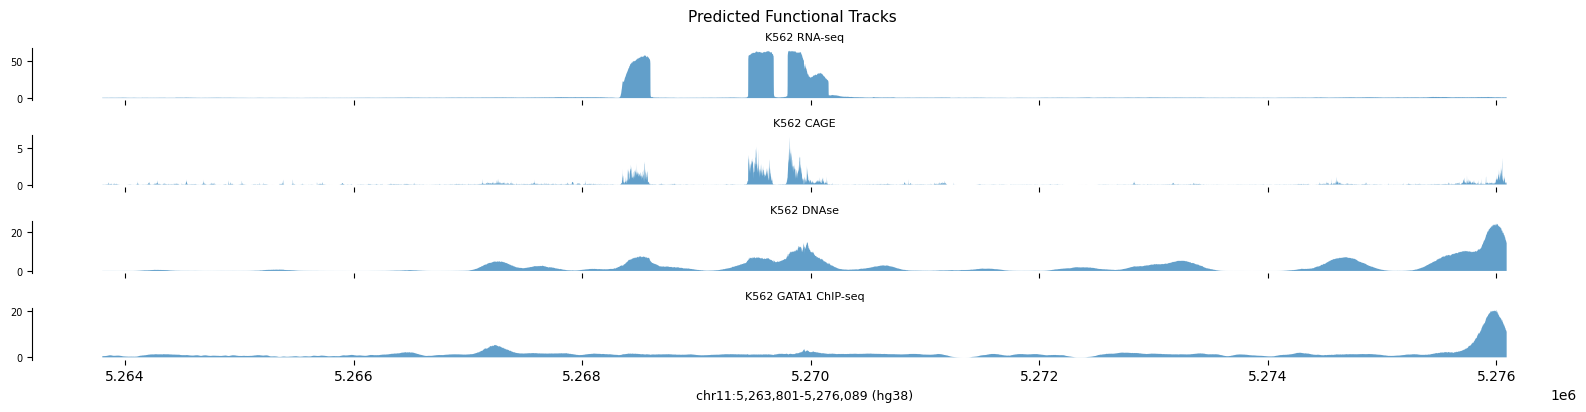

In [11]:
def plot_tracks(tracks, start_pos, end_pos, chrom_name, assembly_name,
                height=1.0):
    """Plot multiple tracks in a stacked view.

    Args:
        tracks: Dictionary mapping track names to 1D arrays of values.
        start_pos: Genomic start position for x-axis.
        end_pos: Genomic end position for x-axis.
        chrom_name: Chromosome name for labeling.
        assembly_name: Assembly name for labeling.
        height: Height multiplier for each track subplot.

    Returns:
        matplotlib.figure.Figure: The created figure object.
    """
    n_tracks = len(tracks)
    fig, axes = plt.subplots(
        n_tracks, 1, figsize=(16, height * n_tracks), sharex=True
    )
    if n_tracks == 1:
        axes = [axes]

    for ax, (title, y) in zip(axes, tracks.items()):
        x_positions = np.linspace(start_pos, end_pos, num=len(y))
        ax.fill_between(x_positions, y, alpha=0.7)
        ax.set_title(title, fontsize=8)
        ax.yaxis.set_label_coords(-0.01, 0.5)
        sns.despine(ax=ax, top=True, right=True, bottom=True)
        ax.tick_params(axis='y', labelsize=7)

    xlabel = f"{chrom_name}:{start_pos:,}-{end_pos:,} ({assembly_name})"
    axes[-1].set_xlabel(xlabel, fontsize=9)
    plt.tight_layout()
    return fig

# Extract and plot functional tracks
bigwig = bigwig_logits.detach().float().cpu().numpy()[0]
bigwig_tracks = {}
for track_name, track_id in tracks_to_plot.items():
    if bigwig_names and track_id in bigwig_names:
        track_idx = bigwig_names.index(track_id)
        bigwig_tracks[track_name] = bigwig[:, track_idx]

if not bigwig_tracks:
    print("⚠️ No tracks to plot (track names may not be available)")
else:
    # Calculate prediction region (center 37.5%)
    window_len = end - start
    prediction_start = start + int(window_len * 0.3125)
    prediction_end = prediction_start + int(window_len * 0.375)

    fig = plot_tracks(
        bigwig_tracks, prediction_start, prediction_end, chrom, assembly
    )
    plt.suptitle("Predicted Functional Tracks", fontsize=11, y=1.02)
    plt.show()

## 6) 🧬 Visualize Genome Annotations

Following the manuscript methods: The genome-annotation head produces a probability vector over 21 annotation classes at each nucleotide. Softmax probabilities are thresholded at p ≥ 0.5 to produce BED-like binary annotation tracks.


In [12]:
# Select genomic elements to plot
elements_to_plot = [
    "exon",
    "enhancer_Tissue_specific",
    "promoter_Tissue_specific",
    "ORF"
]

# Check element availability
elements_to_plot = [e for e in elements_to_plot if e in bed_element_names]
print(f"Plotting {len(elements_to_plot)} genomic elements")


Plotting 4 genomic elements


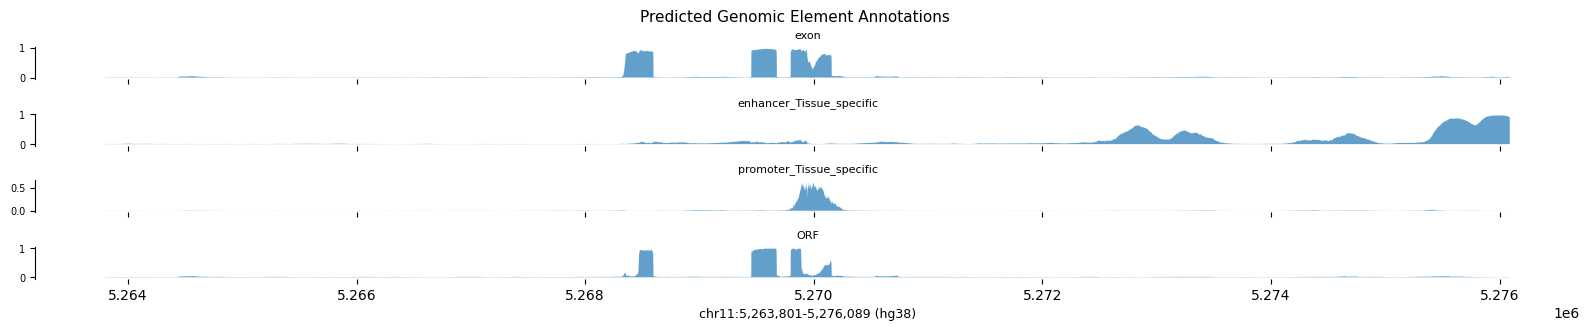

In [13]:
# Convert BED logits to probabilities
bed_array = bed_logits.detach().float().cpu().numpy()[0]
exp = np.exp(bed_array - bed_array.max(axis=-1, keepdims=True))
probs = exp / exp.sum(axis=-1, keepdims=True)

# Extract positive class probabilities for selected elements
bed_probs = {}
for element_name in elements_to_plot:
    element_idx = bed_element_names.index(element_name)
    bed_probs[element_name] = probs[:, element_idx, 1]

# Plot genome annotations
fig = plot_tracks(
    bed_probs, prediction_start, prediction_end, chrom, assembly, height=0.8
)
plt.suptitle("Predicted Genomic Element Annotations", fontsize=11, y=1.02)
plt.show()


## 7) 🔗 Analyze Attention Maps

Following the manuscript methods: Transformer self-attention reveals how NTv3 integrates information across distal regions. We extract multi-head self-attention weights and average them across heads. Matrices are symmetrized as (A + A^T)/2.


In [14]:
# Extract attention from last layer
layer_index = -1  # Last layer
# [heads, seq_len, seq_len]
attention_last_layer = attention_maps[layer_index]

# Average over heads and symmetrize
# [seq_len, seq_len]
attention_mean = attention_last_layer.mean(axis=0)
attention_mean = 0.5 * (attention_mean + attention_mean.T)  # Symmetrize

print(f"Attention map shape: {attention_mean.shape}")
attn_min = attention_mean.min()
attn_max = attention_mean.max()
print(f"Attention value range: [{attn_min:.6f}, {attn_max:.6f}]")


Attention map shape: (256, 256)
Attention value range: [0.000036, 0.216095]


In [15]:
# ============================================================
# Pyramid-style Attention Map Plotting (45-degree rotated triangular)
# ============================================================
from matplotlib.colors import TwoSlopeNorm

# Global settings
LINE_WIDTH = 0.5

def _get_45deg_mesh(mat):
    """Create 45-degree rotated mesh for triangular attention visualization.

    Args:
        mat: Input matrix to create mesh for.

    Returns:
        tuple: (X, Y) mesh coordinates rotated 45 degrees.
    """
    theta = -np.pi / 4
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    K = len(mat) + 1
    g = np.arange(0, K) - 0.5
    X = np.tile(g[:, None], (1, K))
    Y = np.tile(g[None, :], (K, 1))
    xy = np.array([X.ravel(), Y.ravel()])
    xy_rot = R @ xy
    return xy_rot[0, :].reshape(K, K), xy_rot[1, :].reshape(K, K).T

def plot_attention_panel(mat, filename=None, *, cmap="Blues", vmin=0.0001,
                         vmax=0.005, colorbar=True, dpi=600, figsize=(10, 10),
                         variant_id="", show_titles=True, show_xlabel=True,
                         show_xticks=True, show_yticks=False,
                         positions='TOKEN', token_resolution=128, show=True):
    """Plot triangular attention heatmap with 45-degree rotation (pyramid style).

    Args:
        mat: Attention matrix to plot.
        filename: Output filename. If None and show=True, displays plot.
        cmap: Colormap name. Defaults to "Blues".
        vmin: Minimum value for color scale. Defaults to 0.0001.
        vmax: Maximum value for color scale. Defaults to 0.005.
        colorbar: Whether to show colorbar. Defaults to True.
        dpi: Figure DPI. Defaults to 600.
        figsize: Figure size tuple. Defaults to (10, 10).
        variant_id: Title for the plot. Defaults to "".
        show_titles: Whether to show title. Defaults to True.
        show_xlabel: Whether to show x-axis label. Defaults to True.
        show_xticks: Whether to show x-axis ticks. Defaults to True.
        show_yticks: Whether to show y-axis ticks. Defaults to False.
        positions: 'TOKEN' or 'BP' for position units. Defaults to 'TOKEN'.
        token_resolution: Base pairs per token. Defaults to 128.
        show: Whether to display plot. Defaults to True.

    Returns:
        matplotlib.figure.Figure: The created figure object.
    """
    # Symmetrize matrix
    mat = 0.5 * (mat + mat.T)

    # Mask lower triangle
    mat[np.tril_indices_from(mat, k=-1)] = np.nan
    n = mat.shape[0]
    X, Y = _get_45deg_mesh(mat)

    # Coordinate normalization
    C = 1
    half_pixel_diag = 1 / (2*C)
    pixel_side = 1 / (C * np.sqrt(2))
    X = X * pixel_side + half_pixel_diag
    Y = Y * pixel_side
    Y = -Y  # Flip Y

    # Clean up coordinates
    X = np.nan_to_num(X, nan=0.0, posinf=1.0, neginf=-1.0)
    Y = np.nan_to_num(Y, nan=0.0, posinf=1.0, neginf=-1.0)

    # Set up normalization
    vcenter = (vmin + vmax) / 2
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    im = ax.pcolormesh(X, Y, mat, cmap=cmap, norm=norm, shading="auto")

    # Set axis properties
    ax.set_aspect("equal")

    # Calculate coordinate extents
    finite_mask = np.isfinite(mat)
    if finite_mask.any():
        vertex_mask = np.zeros_like(X, dtype=bool)
        vertex_mask[:-1, :-1] |= finite_mask
        vertex_mask[:-1, 1:] |= finite_mask
        vertex_mask[1:, :-1] |= finite_mask
        vertex_mask[1:, 1:] |= finite_mask

        valid_x = X[vertex_mask]
        valid_y = Y[vertex_mask]
        x_min, x_max = np.nanmin(valid_x), np.nanmax(valid_x)
        y_min, y_max = np.nanmin(valid_y), np.nanmax(valid_y)
    else:
        x_min, x_max = np.nanmin(X), np.nanmax(X)
        y_min, y_max = np.nanmin(Y), np.nanmax(Y)

    triangle_bottom_y = y_min
    triangle_top_y = y_max

    xlim_pad = 0.1
    ylim_pad = 0.1
    y_range = (y_max - y_min) if y_max > y_min else 1.0
    bottom_pad = 0.001 * y_range

    ax.set_xlim(x_min - xlim_pad, x_max + xlim_pad)
    ax.set_ylim(y_min - bottom_pad, y_max + ylim_pad)

    # Add colorbar
    if colorbar:
        pyramid_y_min = y_min
        pyramid_y_max = y_max

        cb = plt.colorbar(im, ax=ax, shrink=1.0, aspect=20, pad=0.1)
        cb.ax.tick_params(width=LINE_WIDTH*0.8, length=3, labelsize=7, direction="in")
        cb.outline.set_linewidth(LINE_WIDTH*0.8)

        ax_pos = ax.get_position()
        axes_y_min_data = y_min - bottom_pad
        axes_y_max_data = y_max + ylim_pad
        axes_height_data = axes_y_max_data - axes_y_min_data

        if axes_height_data > 0:
            pyramid_bottom_frac = (
                (pyramid_y_min - axes_y_min_data) / axes_height_data
            )
            pyramid_top_frac = (
                (pyramid_y_max - axes_y_min_data) / axes_height_data
            )
        else:
            pyramid_bottom_frac = 0
            pyramid_top_frac = 1

        cb_pos = cb.ax.get_position()
        new_y0 = ax_pos.y0 + ax_pos.height * pyramid_bottom_frac
        new_height = ax_pos.height * (pyramid_top_frac - pyramid_bottom_frac)
        cb.ax.set_position(
            [cb_pos.x0, new_y0, cb_pos.width, new_height]
        )

    # Format axes
    use_bp_display = positions.upper() == 'BP'

    ax.tick_params(width=LINE_WIDTH, length=3, labelsize=7)
    for sp in ("top", "right", "left"):
        ax.spines[sp].set_visible(False)
    ax.spines["bottom"].set_linewidth(LINE_WIDTH)
    ax.spines["bottom"].set_position(('data', triangle_bottom_y))
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')

    if show_xticks and mat.size > 0:
        n_tokens = mat.shape[0]
        tick_positions = [0, n_tokens - 1]
        if use_bp_display:
            max_bp = (n_tokens - 1) * token_resolution
            tick_labels = ['0', str(max_bp)]
        else:
            tick_labels = ['0', str(n_tokens - 1)]
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
    else:
        ax.set_xticks([])

    if not show_yticks:
        ax.set_yticks([])

    if use_bp_display:
        xlabel_text = "Position (base pairs)"
    else:
        xlabel_text = "Token position"
    if show_xlabel:
        ax.set_xlabel(xlabel_text, fontsize=8)

    if show_titles and variant_id:
        ax.set_title(variant_id, fontsize=9, pad=10)

    ax.set_facecolor("white")

    if filename:
        dirname = os.path.dirname(filename)
        if dirname:
            os.makedirs(dirname, exist_ok=True)
        plt.savefig(
            filename, dpi=600, bbox_inches="tight", facecolor='white'
        )
        print(f"✅ Saved attention plot: {filename}")
        if not show:
            plt.close(fig)
    elif show:
        plt.show()
    else:
        plt.close(fig)

    return fig

print("✅ Pyramid-style attention plotting function defined")

✅ Pyramid-style attention plotting function defined


Plotting attention map:
  Layer: -1
  Window: 1024 tokens (cropped from 256 total)
  Value range: [0.000036, 0.216095]


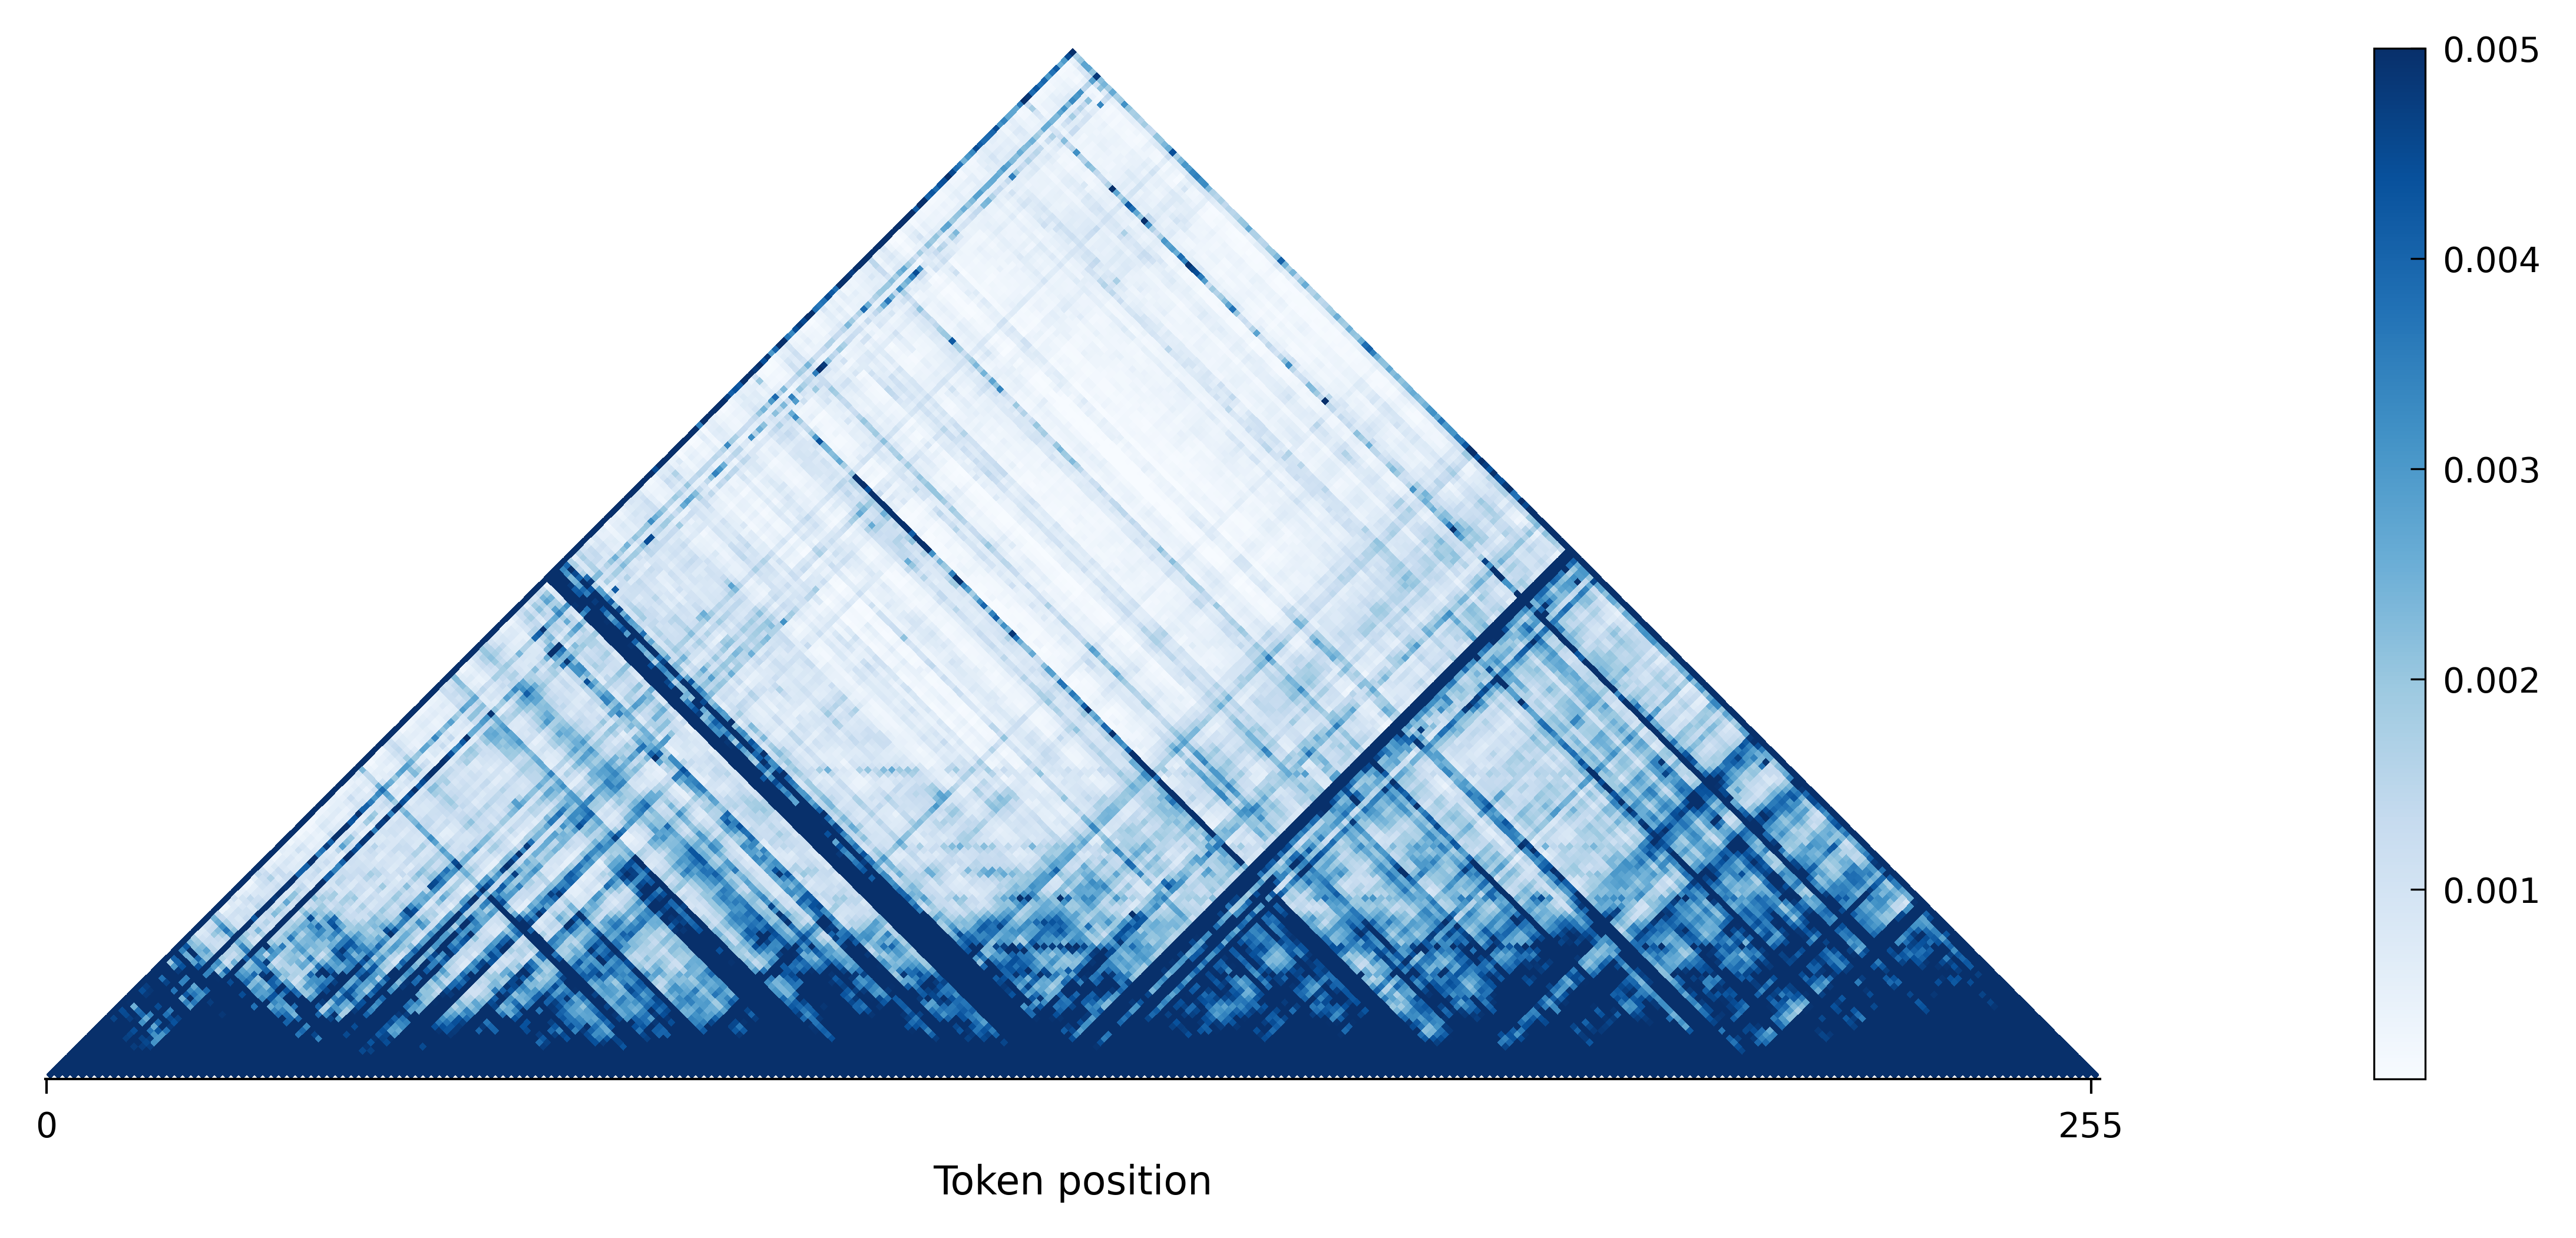

In [16]:
# Plot pyramid-style attention map (cropped to center window)
LAYER_INDEX = layer_index
TOKEN_RESOLUTION = token_resolution
window_size = 1024  # tokens to show

# Crop to center window
n_tokens_full = len(attention_mean)
start_crop = (n_tokens_full - window_size) // 2
end_crop = start_crop + window_size
attention_mean_cropped = attention_mean[
    start_crop:end_crop, start_crop:end_crop
].copy()

print(f"Plotting attention map:")
print(f"  Layer: {LAYER_INDEX}")
print(
    f"  Window: {window_size} tokens "
    f"(cropped from {n_tokens_full} total)"
)
attn_crop_min = attention_mean_cropped.min()
attn_crop_max = attention_mean_cropped.max()
print(f"  Value range: [{attn_crop_min:.6f}, {attn_crop_max:.6f}]")

# Plot with pyramid style using shared utility
title = f"Attention Map - Layer {LAYER_INDEX} (Head Average)"
fig = plot_attention_panel(
    attention_mean_cropped,
    cmap="Blues",
    vmin=0.0001,
    vmax=0.005,
    colorbar=True,
    figsize=(10, 10),
    show_xlabel=True,
    show_xticks=True,
    positions='TOKEN',
    token_resolution=TOKEN_RESOLUTION,
    show=True,
)


## 8) 🎯 Compute Saliency Maps

Following the manuscript methods: Gradient-based attribution provides a first-order, nucleotide-resolved estimate of how NTv3 predictions depend on the underlying DNA sequence. We differentiate model outputs with respect to the one-hot encoded DNA input using a differentiable embedding override.

For the selected functional track(s), we aggregate logits over sequence positions in a window and apply a log transform.


In [17]:
class SaliencyComputer:
    """Compute gradient-based saliency maps (new model API)."""

    def __init__(self, model, tokenizer, track_indices, species="human",
                 device=None, promoter_window_bp=512, token_resolution=128):
        """Initialize saliency computer.

        Args:
            model: The model to compute saliency for.
            tokenizer: Tokenizer for input sequences.
            track_indices: List of track indices to compute saliency for.
            species: Species name. Defaults to "human".
            device: Device to use. If None, auto-detects. Defaults to None.
            promoter_window_bp: Window size in base pairs. Defaults to 512.
            token_resolution: Base pairs per token. Defaults to 128.
        """
        # Auto-detect device if not provided
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"

        self.model = model
        self.tokenizer = tokenizer
        self.track_indices = track_indices
        self.species = species
        self.device = device
        self.promoter_window_bp = promoter_window_bp
        self.token_resolution = token_resolution
        self.vocab_size = tokenizer.vocab_size

        # Encode species using new API (model.encode_species)
        self.species_ids = model.encode_species([species]).to(device)

    def compute_saliency(self, sequence):
        """Compute saliency map for given sequence.

        Args:
            sequence: DNA sequence string to compute saliency for.

        Returns:
            tuple: (gradients, one_hot_sequence) where gradients is the
                saliency scores and one_hot_sequence is the one-hot encoded
                input sequence.
        """
        # Tokenize
        batch = self.tokenizer(
            [sequence],
            add_special_tokens=False,
            padding=True,
            pad_to_multiple_of=128,
            return_tensors="pt"
        )
        token_ids = batch["input_ids"][0].to(self.device)

        # Create one-hot encoding
        one_hot = F.one_hot(
            token_ids, num_classes=self.vocab_size
        ).float()
        one_hot.requires_grad_(True)

        # Forward pass with gradient tracking
        # Get embedding layer (try common paths)
        embedding_layer = None
        if hasattr(self.model, 'core') and hasattr(self.model.core, 'embed_layer'):
            embedding_layer = self.model.core.embed_layer
        elif hasattr(self.model, 'embeddings'):
            embedding_layer = self.model.embeddings
        elif hasattr(self.model, 'embed_tokens'):
            embedding_layer = self.model.embed_tokens

        if embedding_layer is None:
            raise ValueError(
                "Could not find embedding layer in model. "
                "Saliency computation requires access to embedding weights."
            )

        inputs_embeds = torch.matmul(
            one_hot, embedding_layer.weight
        ).unsqueeze(0)

        # Forward pass with inputs_embeds (NOT input_ids - model requires exactly one)
        outputs = self.model(
            input_ids=None,  # Must be None when using inputs_embeds
            species_ids=self.species_ids,
            inputs_embeds=inputs_embeds,
            return_dict=True,
        )

        # Access bigwig logits using attribute-style access
        logits = outputs.bigwig_tracks_logits

        # Focus on center window
        seq_len = logits.shape[1]
        center_token = seq_len // 2
        window_tokens = self.promoter_window_bp // self.token_resolution
        prom_start = max(0, center_token - window_tokens)
        prom_end = min(seq_len, center_token + window_tokens + 1)

        # Select tracks and compute score
        prom_logits = logits[:, prom_start:prom_end, :]
        selected_logits = prom_logits[:, :, self.track_indices]
        score = torch.log(selected_logits.sum() + 1e-6)

        # Backward pass
        score.backward()

        gradients = one_hot.grad.cpu().detach().numpy()
        one_hot_np = one_hot.detach().cpu().numpy()

        return gradients, one_hot_np


In [18]:
# Select track for saliency computation
# You can specify either a track ID (if track names available) or index directly
saliency_track_id = "ENCSR000EFT"  # K562 GATA1 ChIP-seq

# Resolve track index
if bigwig_names and saliency_track_id in bigwig_names:
    saliency_track_idx = bigwig_names.index(saliency_track_id)
    print(
        f"Computing saliency for track: {saliency_track_id} "
        f"(index {saliency_track_idx})"
    )
else:
    # Fallback to using track index directly if names not available
    saliency_track_idx = 0  # Default to first track
    print(
        f"⚠️ Track '{saliency_track_id}' not found or names unavailable. "
        f"Using track index {saliency_track_idx}."
    )

# Use shorter sequence for saliency (faster computation)
saliency_seq_length = len(seq) // 2
seq_start = (len(seq) - saliency_seq_length) // 2
seq_end = seq_start + saliency_seq_length
saliency_seq = seq[seq_start:seq_end]

print(
    f"Saliency sequence: {len(saliency_seq):,} bp "
    f"(center crop of full sequence)"
)


Computing saliency for track: ENCSR000EFT (index 1643)
Saliency sequence: 16,384 bp (center crop of full sequence)


In [19]:
# Initialize saliency computer
saliency_computer = SaliencyComputer(
    model=model,
    tokenizer=tokenizer,
    track_indices=[saliency_track_idx],
    species=species,
    device=device,
    promoter_window_bp=1024,
    token_resolution=token_resolution,
)

# Compute saliency
print("Computing saliency (this may take a moment)...")
saliency_scores, one_hot_sequence = saliency_computer.compute_saliency(
    saliency_seq
)

print(f"\n✅ Saliency computed")
print(f"   Shape: {saliency_scores.shape}")
sal_min = saliency_scores.min()
sal_max = saliency_scores.max()
print(f"   Value range: [{sal_min:.6f}, {sal_max:.6f}]")


Computing saliency (this may take a moment)...

✅ Saliency computed
   Shape: (16384, 11)
   Value range: [-0.139852, 0.178463]


In [20]:
# Apply gradient correction (subtract mean at each position)
saliency_corrected = saliency_scores - np.mean(
    saliency_scores, axis=1, keepdims=True
)

# Calculate genomic positions
saliency_start = start + seq_start


Plotting saliency sequence logo...
  Contribution mode: True
  Window: 5,269,881 - 5,270,009 bp
  Window size: 128 positions


Processing logos: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


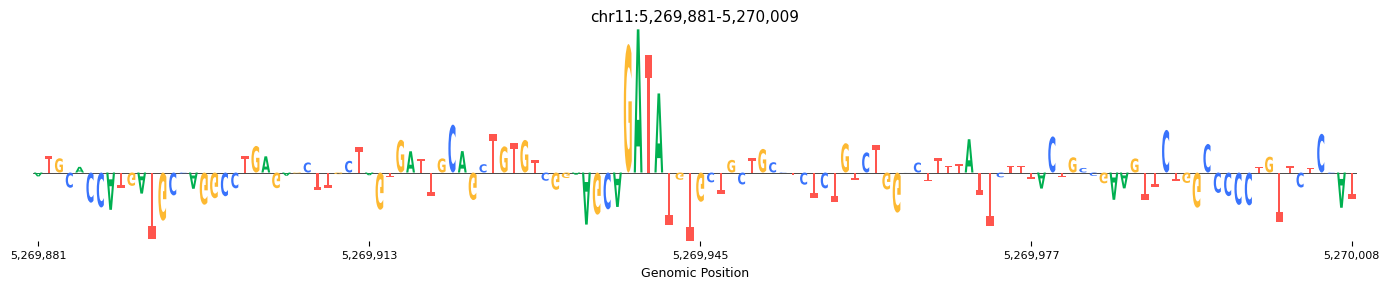


✅ Saliency logo plotted


In [21]:
# Plot saliency sequence logo using BatchLogo
# This provides interpretable nucleotide-resolved gradient visualization

# Try to import BatchLogo
try:
    from seam.logomaker_batch.batch_logo import BatchLogo
    batch_logo_available = True
except ImportError:
    batch_logo_available = False
    print("⚠️ BatchLogo not available. Using simplified visualization.")

# Nucleotide color scheme
NUCLEOTIDE_COLORS = {
    'A': '#00b050',  # green
    'C': '#3973fc',  # blue
    'G': '#fdb932',  # yellow/gold
    'T': '#ff554d'   # red
}

# Configuration for logo plotting
# True = contribution mode (multiply by one-hot), False = hypothetical mode
CONTRIBUTION_MODE = True
LOGO_WINDOW_SIZE = 128  # Number of positions to show in logo

# Calculate window coordinates (saliency is at nucleotide resolution)
n_saliency = len(saliency_corrected)
cropped_start = (n_saliency - LOGO_WINDOW_SIZE) // 2
cropped_end = cropped_start + LOGO_WINDOW_SIZE
window_start_bp = saliency_start + cropped_start
window_end_bp = saliency_start + cropped_end

print(f"Plotting saliency sequence logo...")
print(f"  Contribution mode: {CONTRIBUTION_MODE}")
print(f"  Window: {window_start_bp:,} - {window_end_bp:,} bp")

# Extract nucleotide channels (A=6, T=7, C=8, G=9)
nucleotide_indices = [6, 7, 8, 9]
saliency_acgt = saliency_corrected[:, nucleotide_indices]
one_hot_acgt = one_hot_sequence[:, nucleotide_indices]

if CONTRIBUTION_MODE:
    saliency_acgt = saliency_acgt * one_hot_acgt

# Extract window
window_saliency = saliency_acgt[cropped_start:cropped_end]
print(f"  Window size: {len(window_saliency)} positions")

if batch_logo_available:
    try:
        logo_batch = window_saliency[np.newaxis, :, :]
        logo_processor = BatchLogo(
            logo_batch,
            alphabet=['A', 'T', 'C', 'G'],
            font_name='DejaVu Sans',
            font_weight='bold',
            color_scheme=NUCLEOTIDE_COLORS,
            fade_below=0.0,
            shade_below=0.0,
            width=0.9,
            figsize=(14, 3),
            center_values=not CONTRIBUTION_MODE,
            border=False,
            fixed_ylim=True,
            batch_size=1
        )
        logo_processor.process_all()
        fig, ax = logo_processor.draw_single(0, border=False)
        logo_title = f'{chrom}:{window_start_bp:,}-{window_end_bp:,}'
        ax.set_title(logo_title, fontsize=11)

        # Set x-axis ticks to show genomic positions
        n_positions = len(window_saliency)
        tick_positions = [0, n_positions // 4, n_positions // 2,
                          3 * n_positions // 4, n_positions - 1]
        tick_labels = [f'{window_start_bp + pos:,}' for pos in tick_positions]
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, fontsize=8)
        ax.set_xlabel('Genomic Position', fontsize=9)

        plt.yticks([])
        plt.tight_layout()
        plt.show()
        print(f"\n✅ Saliency logo plotted")
    except Exception as e:
        print(f"  ⚠️ Error creating BatchLogo: {e}")
        batch_logo_available = False

if not batch_logo_available:
    # Fallback: simplified bar plot visualization
    fig, ax = plt.subplots(figsize=(14, 4))
    x_pos = np.arange(len(window_saliency))
    width = 0.2

    nuc_colors = [
        NUCLEOTIDE_COLORS['A'],
        NUCLEOTIDE_COLORS['T'],
        NUCLEOTIDE_COLORS['C'],
        NUCLEOTIDE_COLORS['G']
    ]
    for j, (nuc, color) in enumerate(zip(['A', 'T', 'C', 'G'], nuc_colors)):
        values = window_saliency[:, j]
        ax.bar(
            x_pos + j * width,
            values,
            width,
            label=nuc,
            color=color,
            alpha=0.8
        )

    # Set x-axis ticks to show genomic positions
    n_positions = len(window_saliency)
    tick_positions = [0, n_positions // 4, n_positions // 2,
                      3 * n_positions // 4, n_positions - 1]
    tick_labels = [f'{window_start_bp + pos:,}' for pos in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, fontsize=8)
    ax.set_xlabel('Genomic Position', fontsize=9)

    ax.set_ylabel('Saliency', fontsize=9)
    logo_title = f'{chrom}:{window_start_bp:,}-{window_end_bp:,}'
    ax.set_title(logo_title, fontsize=11)
    ax.legend(loc='upper right', fontsize=8)
    ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
    sns.despine()
    plt.tight_layout()
    plt.show()
    print(f"\n✅ Saliency logo plotted (simplified)")


## 📝 Summary

This notebook demonstrated the four complementary interpretability modalities of the NTv3 model:

- ✅ **Functional tracks**: Predicted regulatory activity across thousands of assays
- ✅ **Genome annotations**: Gene-structural and regulatory element predictions
- ✅ **Attention maps**: Long-range information integration patterns
- ✅ **Saliency maps**: Gradient-based sequence attributions

### 💡 Next Steps

- Try different genomic regions by changing `chrom`, `center_position`
- Explore different tracks by modifying `tracks_to_plot`
- Compare attention patterns across different layers
- Compute saliency for different track combinations

### 📚 Additional Resources

- For a streamlined pipeline interface, see the companion notebook: `02_functional_interpretation.ipynb`
- For track prediction tutorials, see: [01_tracks_prediction.ipynb](https://huggingface.co/spaces/InstaDeepAI/ntv3/blob/main/notebooks_tutorials/01_tracks_prediction.ipynb)
